In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from glob import glob
from PIL import Image
import os
import cv2
import scipy.ndimage as ndimage
from skimage import io
from numpy import expand_dims


In [2]:
from sklearn.model_selection import train_test_split


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms

In [4]:
imagepatches = glob('../data/raw/**/*.png', recursive=True)
len(imagepatches) # number of images

277524

In [5]:
imagepath=pd.DataFrame(imagepatches,columns=['path']) # taking path of the images in the dataframe
imagepath.head()

,path
0,../data/raw/9036/0/9036_idx5_x1051_y2401_class...
1,../data/raw/9036/0/9036_idx5_x2951_y951_class0...
2,../data/raw/9036/0/9036_idx5_x3001_y1451_class...
3,../data/raw/9036/0/9036_idx5_x3051_y801_class0...
4,../data/raw/9036/0/9036_idx5_x951_y1901_class0...


In [6]:
file_split = imagepath['path'].str.split('_')
file_split

0         [../data/raw/9036/0/9036, idx5, x1051, y2401, ...
1         [../data/raw/9036/0/9036, idx5, x2951, y951, c...
2         [../data/raw/9036/0/9036, idx5, x3001, y1451, ...
3         [../data/raw/9036/0/9036, idx5, x3051, y801, c...
4         [../data/raw/9036/0/9036, idx5, x951, y1901, c...
                                ...                        
277519    [../data/raw/8957/1/8957, idx5, x1951, y701, c...
277520    [../data/raw/8957/1/8957, idx5, x2051, y551, c...
277521    [../data/raw/8957/1/8957, idx5, x1951, y651, c...
277522    [../data/raw/8957/1/8957, idx5, x1451, y551, c...
277523    [../data/raw/8957/1/8957, idx5, x1601, y501, c...
Name: path, Length: 277524, dtype: object

In [7]:
#Getting patient id, class, x and  y coordinates in a dataframe
imagepath['patientid'] = [x[0] for x in file_split]
imagepath['x'] = [x[2] for x in file_split]
imagepath['y'] = [x[-2] for x in file_split]
imagepath['Class_png']=[x[-1] for x in file_split]

In [8]:
fs = imagepath['patientid'].str.split('/')
imagepath['P_id']=[x[-1] for x in fs]

In [9]:
imagepath['X'] = imagepath['x'].str.extract('(\d+)', expand=False)
imagepath['Y'] = imagepath['y'].str.extract('(\d+)', expand=False)
imagepath['Class'] = imagepath['Class_png'].str.extract('(\d+)', expand=False)
imagepath=imagepath.drop(['Class_png'],axis=1)
imagepath=imagepath.drop(['x'],axis=1)
imagepath=imagepath.drop(['y'],axis=1)
imagepath=imagepath.drop(['patientid'],axis=1)

In [10]:
imagepath.shape

(277524, 5)

In [11]:
imagepath.head()

,path,P_id,X,Y,Class
0,../data/raw/9036/0/9036_idx5_x1051_y2401_class...,9036,1051,2401,0
1,../data/raw/9036/0/9036_idx5_x2951_y951_class0...,9036,2951,951,0
2,../data/raw/9036/0/9036_idx5_x3001_y1451_class...,9036,3001,1451,0
3,../data/raw/9036/0/9036_idx5_x3051_y801_class0...,9036,3051,801,0
4,../data/raw/9036/0/9036_idx5_x951_y1901_class0...,9036,951,1901,0


In [12]:
imagepath.Class.value_counts()

0    198738
1     78786
Name: Class, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

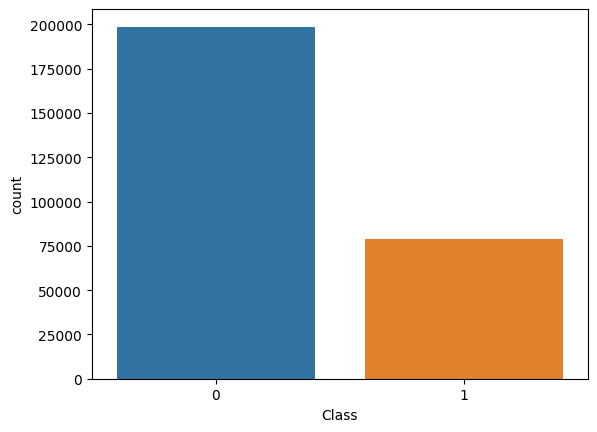

In [13]:
sns.countplot(x="Class",data=imagepath)

In [14]:
imagepath['Class']=imagepath.Class.astype(np.int64)
imagepath['X']=imagepath.X.astype(np.int64)
imagepath['Y']=imagepath.Y.astype(np.int64)
imagepath['P_id']=imagepath.P_id.astype(np.int64)

In [15]:
imagepath.dtypes

path     object
P_id      int64
X         int64
Y         int64
Class     int64
dtype: object

In [16]:
patients=imagepath.P_id.unique()

In [17]:
len(patients) #Number of patients

279

In [433]:
#train test split according to patients
train_patients,testpatients=train_test_split(patients,test_size=0.3)
test_patients,val_patients=train_test_split(testpatients,test_size=0.5)

print(len(train_patients),len(val_patients),len(test_patients))

195 42 42


In [434]:
#dataframes for training, validation, test patients id
train_df=imagepath[imagepath.P_id.isin(train_patients)]
val_df=imagepath[imagepath.P_id.isin(val_patients)]
test_df=imagepath[imagepath.P_id.isin(test_patients)]

In [435]:
train_df.Class.value_counts(),val_df.Class.value_counts(),test_df.Class.value_counts()

(0    136550
 1     52956
 Name: Class, dtype: int64,
 0    33820
 1    13442
 Name: Class, dtype: int64,
 0    28368
 1    12388
 Name: Class, dtype: int64)

In [1]:
train_df

NameError: name 'train_df' is not defined

<Figure size 1000x1000 with 0 Axes>

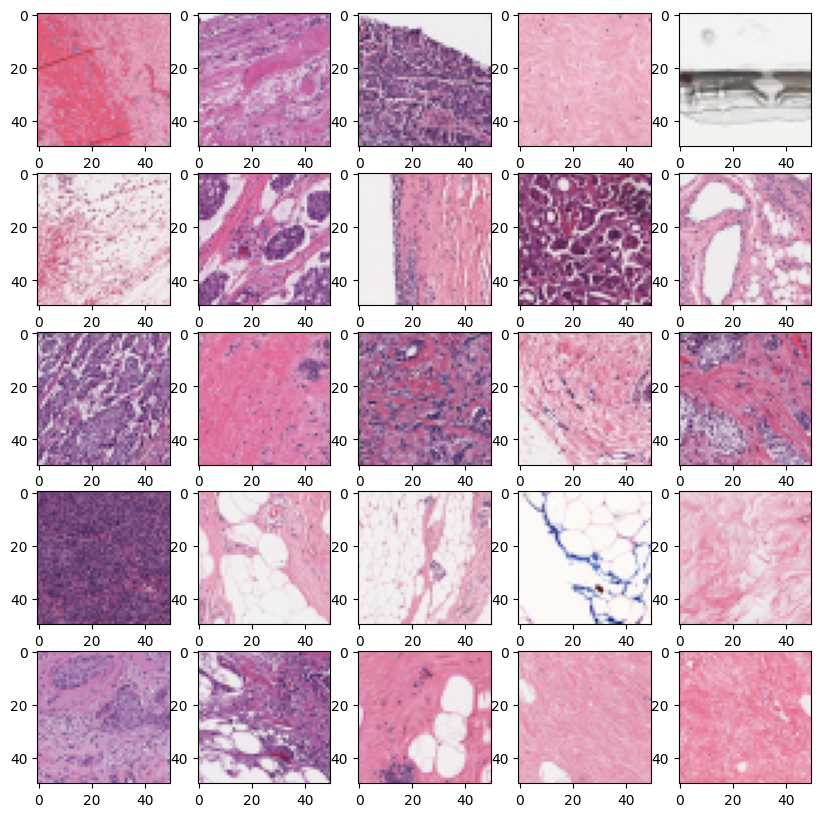

In [417]:
#Glimpse of images
plt.figure(figsize= (10,10))
#plt.suptitle("Benign tumor")

imgs = np.random.randint(0, len(imagepath.path), 25)
i=0
batch_size = len(imgs)
batch = torch.zeros(batch_size, 3,50, 50, dtype=torch.uint8)
for i, filename in enumerate(imgs):
    batch[i] = torchvision.io.read_image(imagepath.path[filename])

fig = plt.figure(figsize=(10, 10))
for i in range(batch.shape[0]) :
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(batch[i].permute(1, 2, 0))

In [436]:
train_df.to_csv("../data/processed/trainpath_df3.csv",index=False)
val_df.to_csv("../data/processed/valpath_df3.csv",index=False)
test_df.to_csv("../data/processed/testpath_df3.csv",index=False)

In [31]:
train_df

,path,P_id,X,Y,Class
4050,../data/raw/8913/0/8913_idx5_x2451_y301_class0...,8913,2451,301,0
4051,../data/raw/8913/0/8913_idx5_x2101_y851_class0...,8913,2101,851,0
4052,../data/raw/8913/0/8913_idx5_x2601_y451_class0...,8913,2601,451,0
4053,../data/raw/8913/0/8913_idx5_x501_y101_class0.png,8913,501,101,0
4054,../data/raw/8913/0/8913_idx5_x2451_y401_class0...,8913,2451,401,0
...,...,...,...,...,...
277519,../data/raw/8957/1/8957_idx5_x1951_y701_class1...,8957,1951,701,1
277520,../data/raw/8957/1/8957_idx5_x2051_y551_class1...,8957,2051,551,1
277521,../data/raw/8957/1/8957_idx5_x1951_y651_class1...,8957,1951,651,1
277522,../data/raw/8957/1/8957_idx5_x1451_y551_class1...,8957,1451,551,1
